In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=32)
parser.add_argument("--nout", type=int, default=10)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=100)
args, unknown = parser.parse_known_args()
args = vars(args)
#args = vars(parser.parse_args())
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]

In [3]:
lattice = lt.Lattice(lt.D3Q27, device = "cpu", dtype=torch.float64)
flow = lt.TaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=0.05, lattice=lattice)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

In [4]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/1)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_sij(lattice, flow)
Enstrophy=lt.Enstrophy(lattice, flow)

reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2 = lt.ObservableReporter(Dissipation_TGV,interval = interval_out, out=None)
reporter3= lt.ObservableReporter(Enstrophy, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(reporter3)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps = int(flow.units.convert_time_to_lu(tmax))
print(steps)
#simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_sij
steps     time     Enstrophy
1764


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
print("Performance in MLUPS:", mlups)
print(steps)

Performance in MLUPS: 1.6286021688003893
1764


In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
enstrophy=np.array(simulation.reporters[2].out)

dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*2)**3])
dissipationEns=np.array([enstrophy[:,1],flow.units.viscosity_pu/(np.pi*2)**3*enstrophy[:,2]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)




[31.00627668 30.99001432 30.94662007 30.90179553 30.84818861 30.81651611
 30.80518089 30.78779935 30.7665722  30.72051831 30.69550722 30.66363776
 30.62675375 30.5718522  30.53092529 30.51309756 30.49516214 30.47647781
 30.43992902 30.41291975 30.38169991 30.345469   30.29103021 30.24162039
 30.22040667 30.20997075 30.19301884 30.1570455  30.12483026 30.09158855
 30.05789896 30.01160542 29.96285817 29.93225942 29.9177581  29.90194916
 29.86610677 29.8331211  29.80576053 29.77544346 29.73016576 29.67758311
 29.63760843 29.61777682 29.60761023 29.58128003 29.54518629 29.51309382
 29.48299466 29.43850878 29.38640505 29.34624272 29.32364549 29.31065251
 29.28606576 29.24823166 29.21120174 29.18413811 29.14949984 29.0981096
 29.04988695 29.01999496 29.0026402  28.9806838  28.94913152 28.91357945
 28.88280713 28.84888247 28.79889104 28.74427615 28.70939766 28.69471385
 28.67597754 28.64351391 28.6047495  28.56938042 28.53565606 28.49321146
 28.44167689 28.3987079  28.37647719 28.35767568 28.

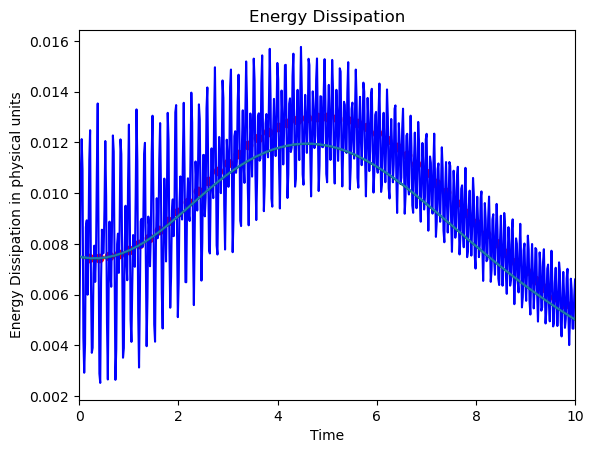

In [7]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(energy[:,2])
plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
plt.title('Energy Dissipation')
#plt.plot(energy[:,1],energy[:,2])
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()

